In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return (df.values).T

pricesFile="prices.txt"
prices = loadPrices(pricesFile)
prices.shape

(50, 1000)

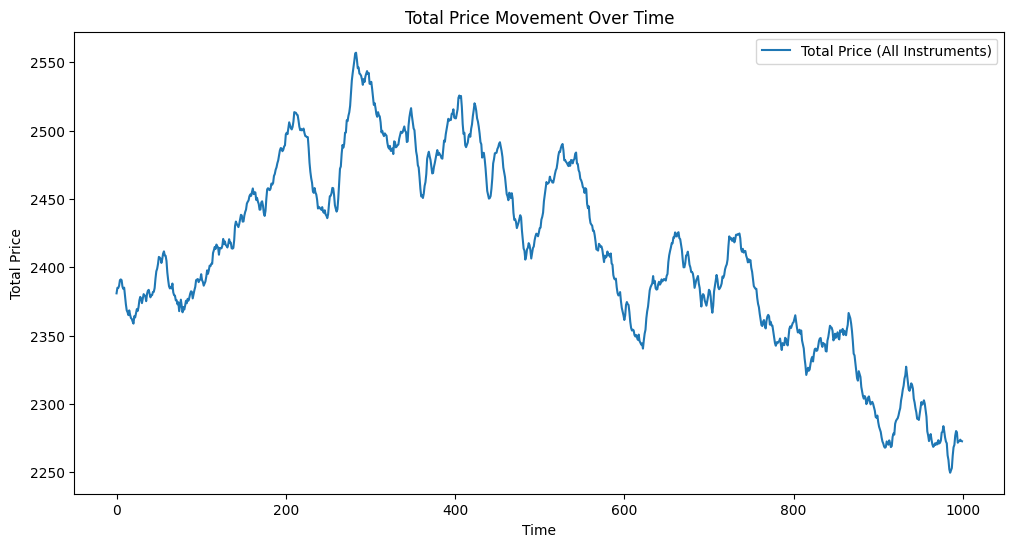

In [2]:
# Sum the prices of all instruments over time
total_price = pd.Series(prices.sum(axis=0))

plt.figure(figsize=(12, 6))
plt.plot(total_price, label='Total Price (All Instruments)')
plt.title('Total Price Movement Over Time')
plt.xlabel('Time')
plt.ylabel('Total Price')
plt.legend()
plt.show()


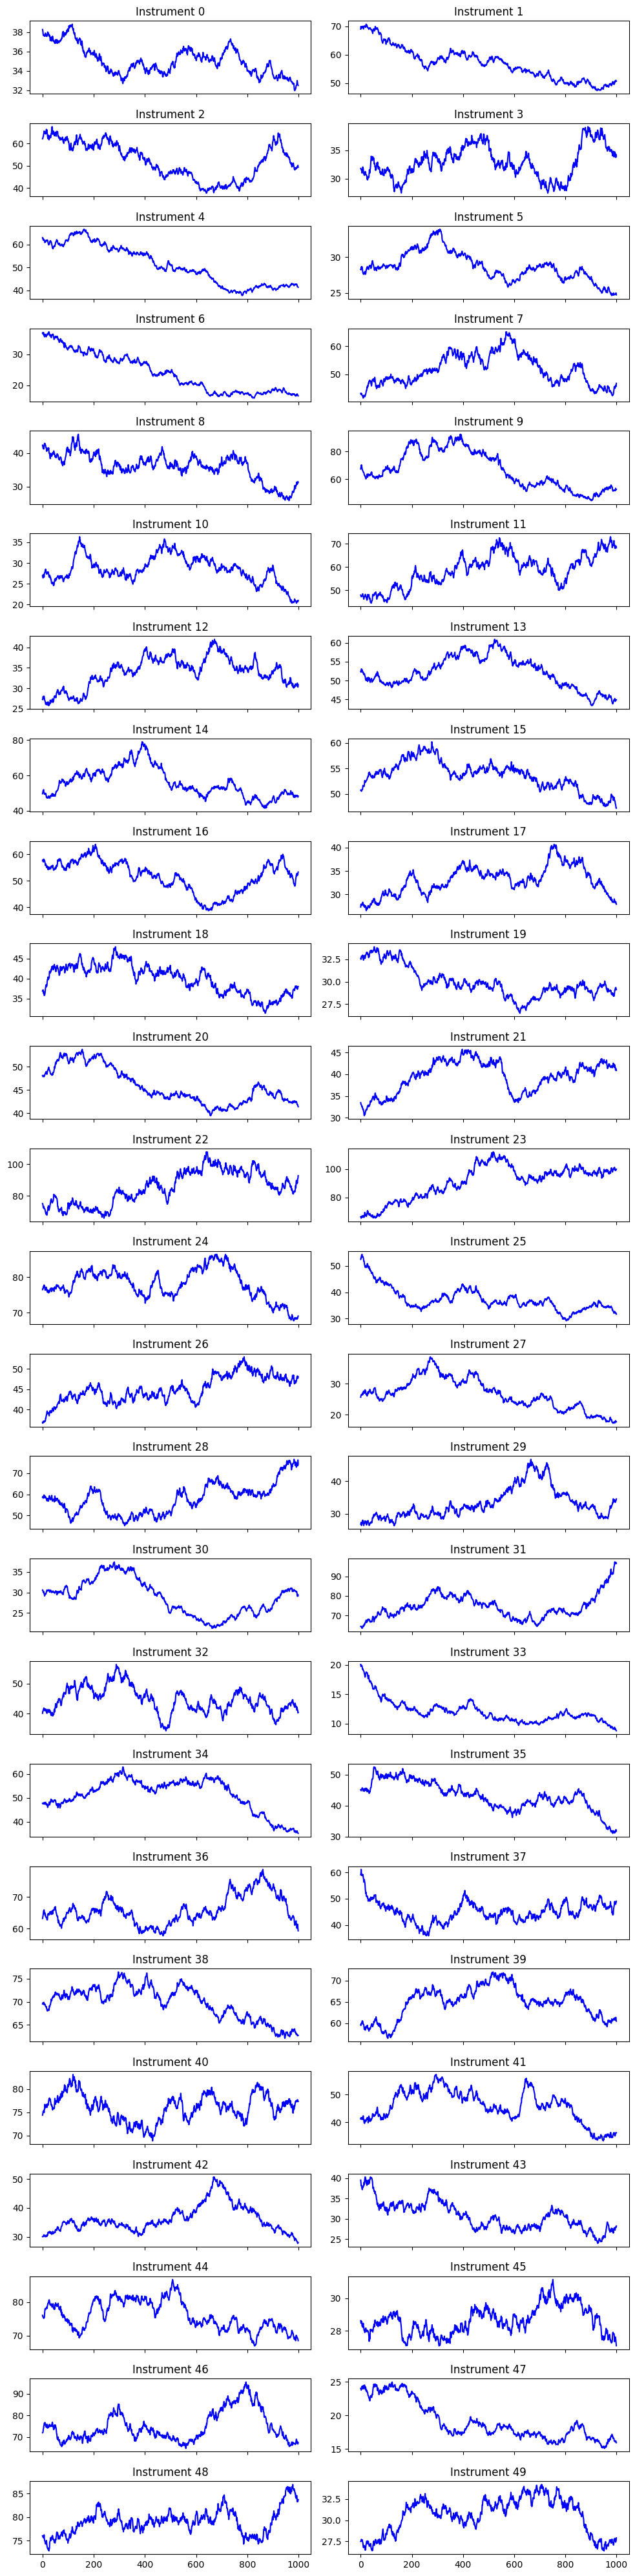

In [3]:
fig, axes = plt.subplots(25, 2, figsize=(10, 40), sharex=True)
axes = axes.flatten()
for inst in range(nInst):
    prc = pd.Series(prices[inst])
    axes[inst].plot(prc, color='blue')
    axes[inst].set_title(f'Instrument {inst}')
plt.tight_layout()
plt.show()


108 long signals found
90 short signals found


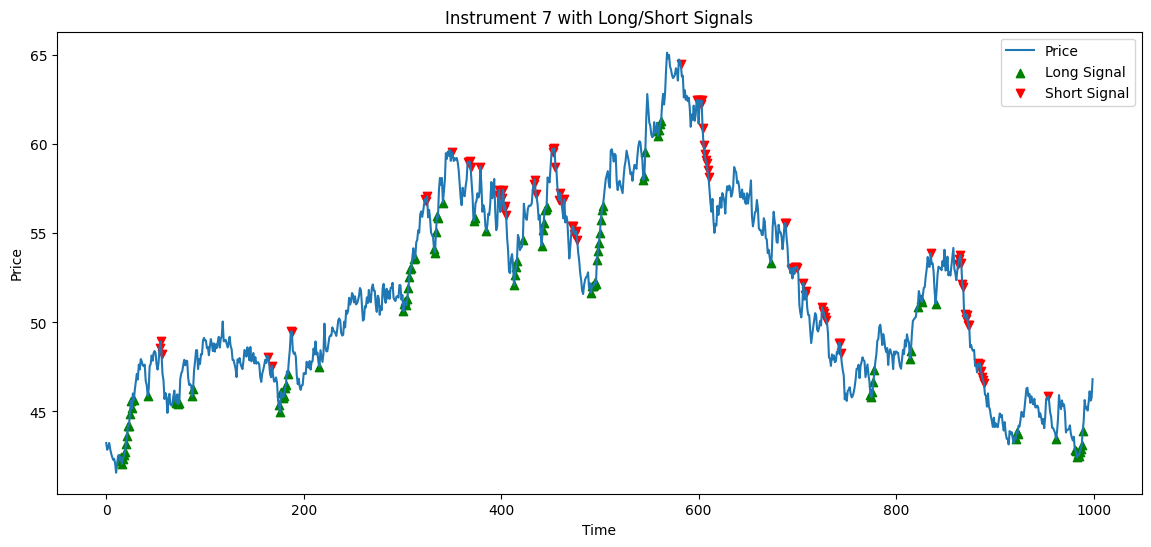

In [4]:
import numpy as np
import pandas as pd

def generate_long_short_signals(prices, lookahead=10, up_thresh=0.05, down_thresh=-0.05, stop_loss=0.01):
    """
    prices: 1D np.array or pd.Series of prices
    lookahead: number of days to look ahead for the signal
    up_thresh: threshold for long signal (e.g., 0.02 for +2%)
    down_thresh: threshold for short signal (e.g., -0.02 for -2%)
    stop_loss: threshold for stop (e.g., 0.01 for 1%)
    Returns: long_signals, short_signals (indices)
    """
    prices = np.asarray(prices)
    n = len(prices)
    long_signals = []
    short_signals = []
    for t in range(n - lookahead):
        future = prices[t+1:t+1+lookahead]
        rel = (future - prices[t]) / prices[t]
        # Long: +2% before -1%
        up_idx = np.where(rel >= up_thresh)[0]
        down_idx = np.where(rel <= -stop_loss)[0]
        if len(up_idx) > 0:
            first_up = up_idx[0]
            if len(down_idx) == 0 or first_up < down_idx[0]:
                long_signals.append(t)
        # Short: -2% before +1%
        down_idx2 = np.where(rel <= down_thresh)[0]
        up_idx2 = np.where(rel >= stop_loss)[0]
        if len(down_idx2) > 0:
            first_down = down_idx2[0]
            if len(up_idx2) == 0 or first_down < up_idx2[0]:
                short_signals.append(t)
    return np.array(long_signals), np.array(short_signals)

# Example usage for one instrument:
inst = 7
p = prices[inst]
longs, shorts = generate_long_short_signals(p)

print(len(longs), "long signals found")
print(len(shorts), "short signals found")
# Plot
plt.figure(figsize=(14,6))
plt.plot(p, label='Price')
plt.scatter(longs, p[longs], marker='^', color='green', label='Long Signal')
plt.scatter(shorts, p[shorts], marker='v', color='red', label='Short Signal')
plt.title(f'Instrument {inst} with Long/Short Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

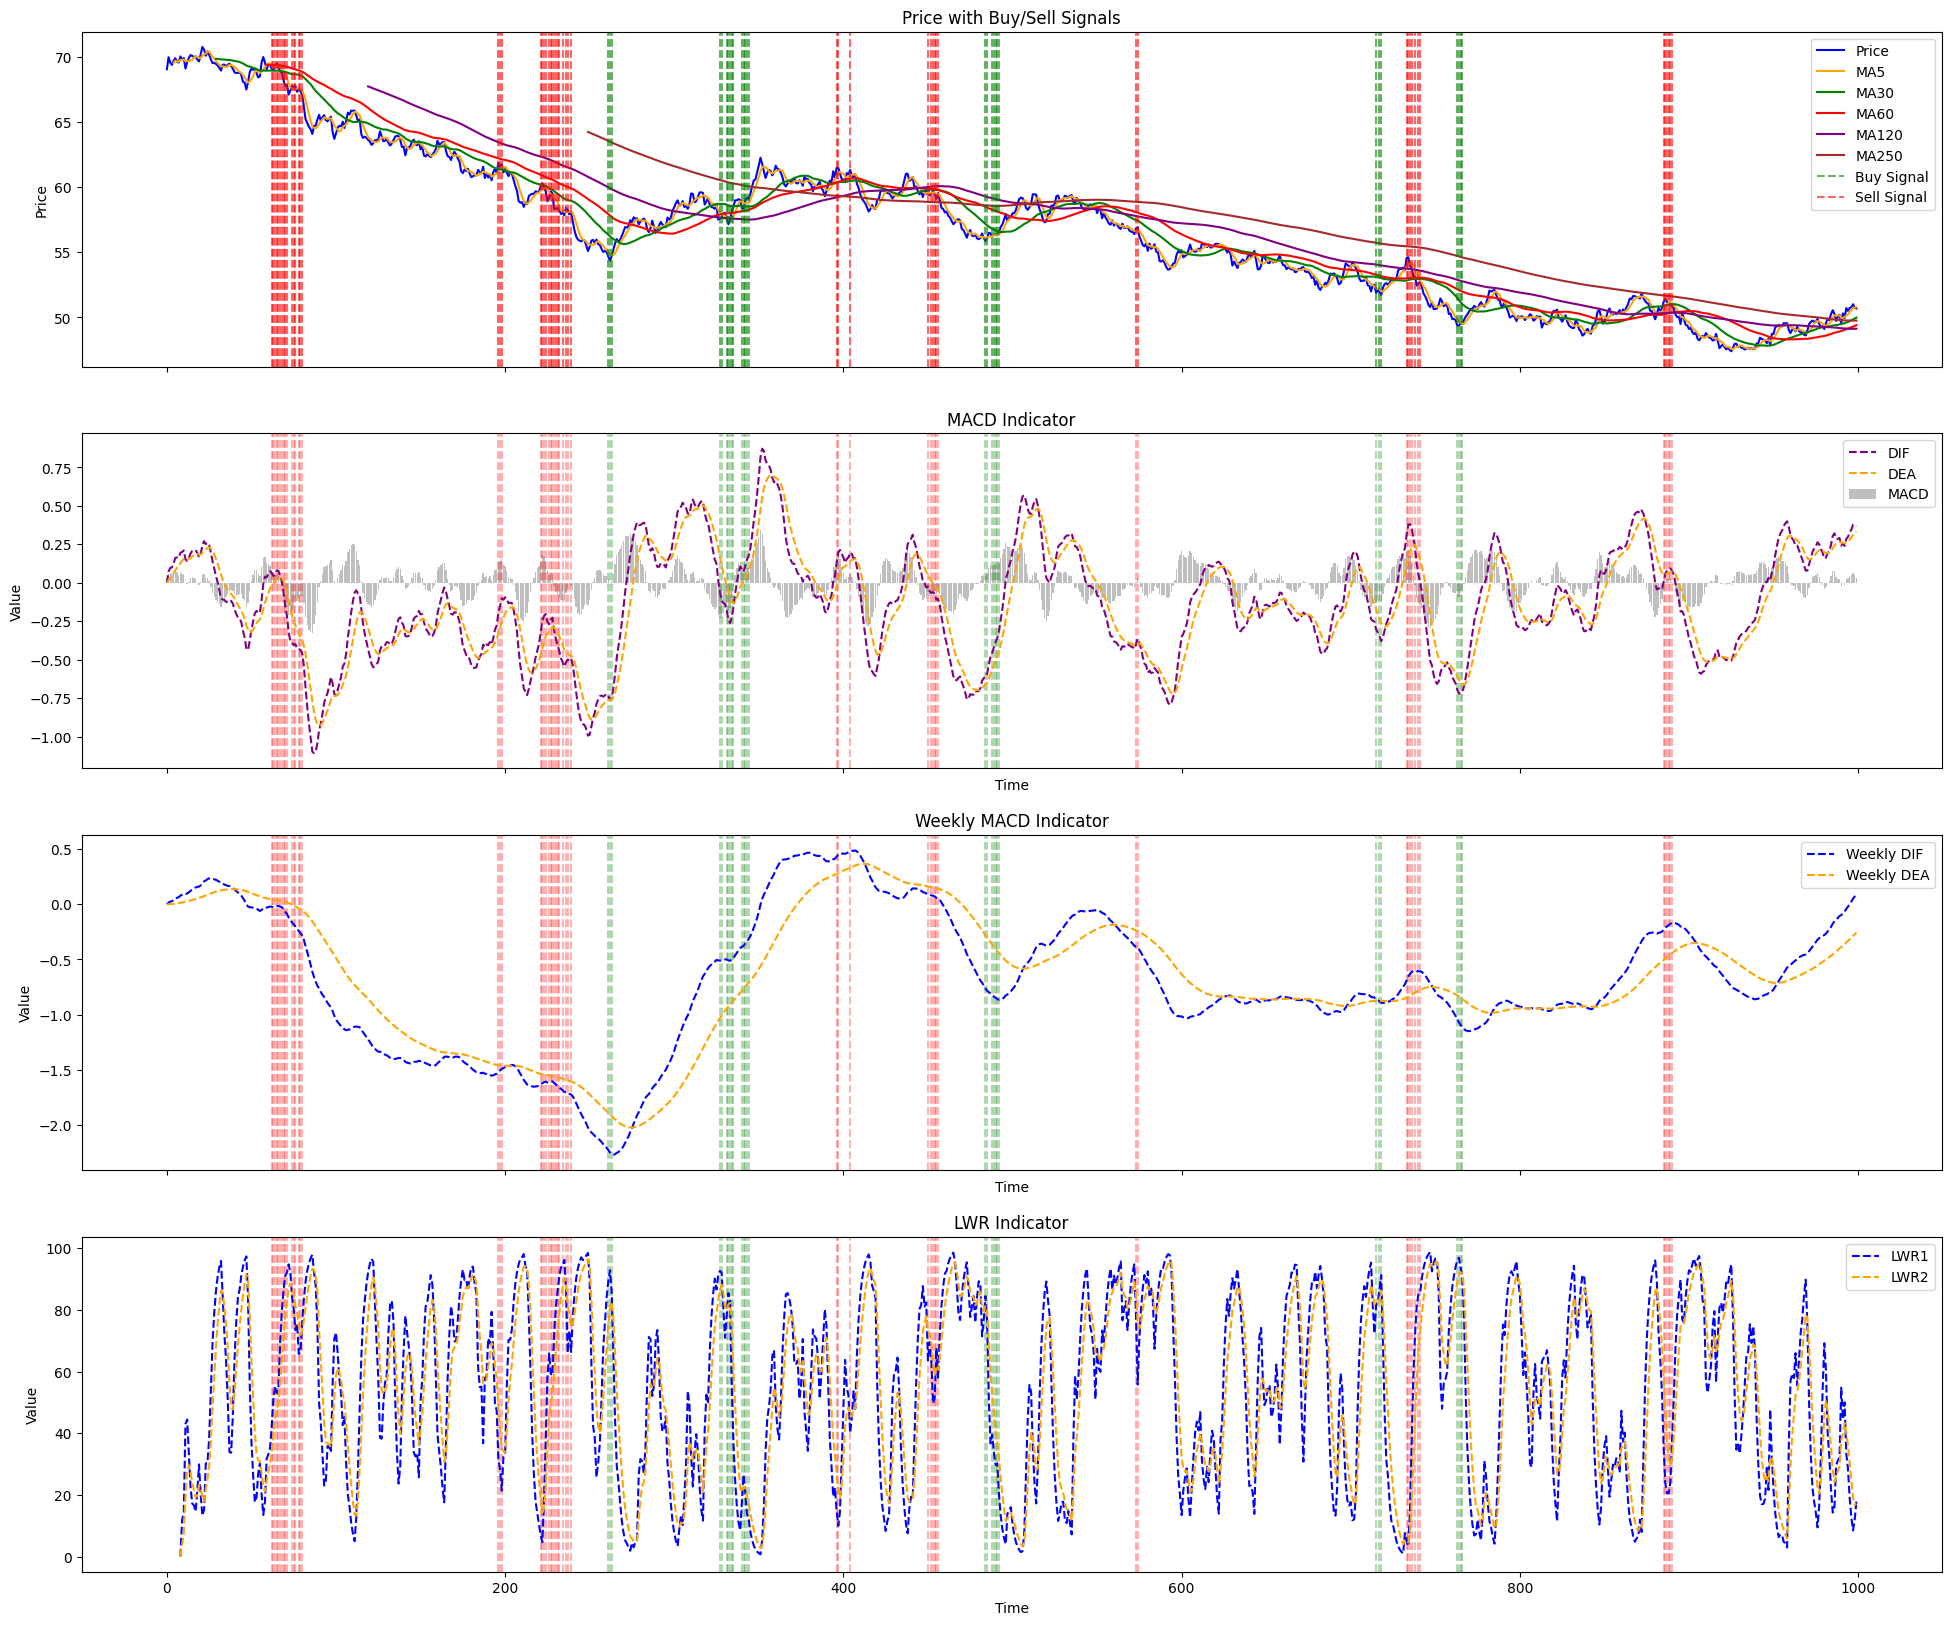

In [ ]:
# Example usage for one instrument:
inst = 1
p = prices[inst]
buy_signals, sell_signals = generate_long_short_signals(p, lookahead=20, up_thresh=0.05, down_thresh=-0.05, stop_loss=0.01)
ma5 = pd.Series(p).rolling(window=5).mean()
ma30 = pd.Series(p).rolling(window=30).mean()
ma60 = pd.Series(p).rolling(window=60).mean()
ma120 = pd.Series(p).rolling(window=120).mean()
ma250 = pd.Series(p).rolling(window=250).mean()
short, long, signal = 12, 26, 9
p_series = pd.Series(p)
ema_short = p_series.ewm(span=short, adjust=False).mean()
ema_long = p_series.ewm(span=long, adjust=False).mean()
dif = ema_short - ema_long
dea = dif.ewm(span=signal, adjust=False).mean()
macd = dif - dea

week_ema_short = p_series.ewm(span=short*5, adjust=False).mean()
week_ema_long = p_series.ewm(span=long*5, adjust=False).mean()
week_dif = week_ema_short - week_ema_long
week_dea = week_dif.ewm(span=signal*5, adjust=False).mean()

n, m1 = 9, 3
alpha = 1 / m1
high_n = p_series.rolling(n).max()
low_n = p_series.rolling(n).min()
rsv = (high_n - p_series) / (high_n - low_n) * 100
lwr1 = rsv.ewm(alpha=alpha, adjust=False).mean()
lwr2 = lwr1.ewm(alpha=alpha, adjust=False).mean()


# Generate buy/sell signals
# buy_signals = []
# sell_signals = []

# for i in range(1, len(p_series)):
#     # Sell: MACD > 0 and DIF crosses below DEA
#     if lwr1[i] < 20 and lwr2[i] < 20:
#         sell_signals.append(i)
#     # Buy: MACD < 0 and DIF crosses above DEA
#     if lwr1[i] > 80 and lwr2[i] > 80:
#         buy_signals.append(i)
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(24, 20), sharex=True)

# Top plot: price with buy/sell signals
ax1.plot(p_series, label='Price', color='blue')
ax1.plot(ma5, label='MA5', color='orange')
ax1.plot(ma30, label='MA30', color='green')
ax1.plot(ma60, label='MA60', color='red')
ax1.plot(ma120, label='MA120', color='purple')
ax1.plot(ma250, label='MA250', color='brown')
for idx in buy_signals:
    ax1.axvline(x=idx, color='green', linestyle='--', alpha=0.6, label='Buy Signal' if idx == buy_signals[0] else "")
for idx in sell_signals:
    ax1.axvline(x=idx, color='red', linestyle='--', alpha=0.6, label='Sell Signal' if idx == sell_signals[0] else "")
ax1.set_title('Price with Buy/Sell Signals')
ax1.set_ylabel('Price')
ax1.legend()

# Add the same vertical lines to the other subplots for persistence
for idx in buy_signals:
    ax2.axvline(x=idx, color='green', linestyle='--', alpha=0.3)
    ax3.axvline(x=idx, color='green', linestyle='--', alpha=0.3)
    ax4.axvline(x=idx, color='green', linestyle='--', alpha=0.3)
for idx in sell_signals:
    ax2.axvline(x=idx, color='red', linestyle='--', alpha=0.3)
    ax3.axvline(x=idx, color='red', linestyle='--', alpha=0.3)
    ax4.axvline(x=idx, color='red', linestyle='--', alpha=0.3)

# Bottom plot: MACD lines
ax2.plot(dif, label='DIF', linestyle='--', color='purple')
ax2.plot(dea, label='DEA', linestyle='--', color='orange')
ax2.bar(range(len(macd)), macd, label='MACD', color='gray', alpha=0.5)
ax2.set_title('MACD Indicator')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend()

ax3.plot(week_dif, label='Weekly DIF', linestyle='--', color='blue')
ax3.plot(week_dea, label='Weekly DEA', linestyle='--', color='orange')
ax3.set_title('Weekly MACD Indicator')
ax3.set_xlabel('Time')
ax3.set_ylabel('Value')
ax3.legend()

# Bottom plot: LWR lines
ax4.plot(lwr1, label='LWR1', linestyle='--', color='blue')
ax4.plot(lwr2, label='LWR2', linestyle='--', color='orange')
ax4.set_title('LWR Indicator')
ax4.set_xlabel('Time')
ax4.set_ylabel('Value')
ax4.legend()

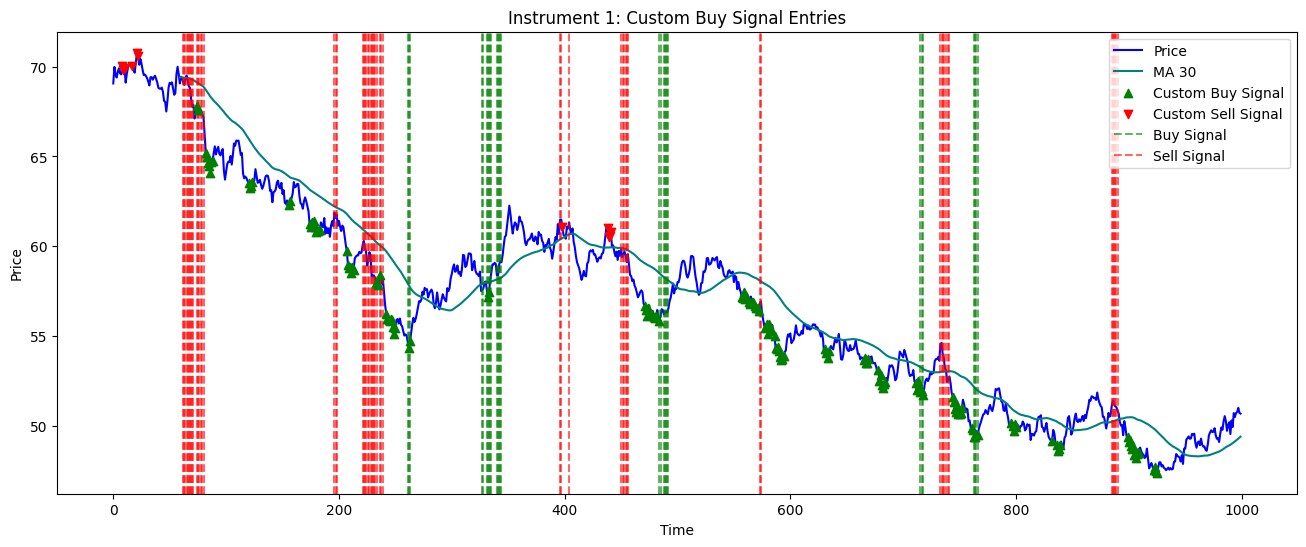

Custom buy signals found: 151


In [ ]:
# Define your custom signal: buy when daily and weekly MACD < 0, and LWR1 & LWR2 > 80
buy_entries = []
for i in range(1, len(p)):
    daily_macd_cond = (dif[i] < 0) and (dea[i] < 0)
    weekly_macd_cond = (week_dif[i] < 0) and (week_dea[i] < 0)
    lwr_cond = (lwr1[i] > 80) and (lwr2[i] > 80)
    if daily_macd_cond and weekly_macd_cond and lwr_cond:
        buy_entries.append(i)

# Define your custom sell signal: sell when daily and weekly MACD > 0, and LWR1 & LWR2 < 20
sell_entries = []
for i in range(1, len(p)):
    daily_macd_cond = (dif[i] > 0) and (dea[i] > 0)
    weekly_macd_cond = (week_dif[i] > 0) and (week_dea[i] > 0)
    lwr_cond = (lwr1[i] < 20) and (lwr2[i] < 20)
    if daily_macd_cond and weekly_macd_cond and lwr_cond:
        sell_entries.append(i)

# Plot price and entry points
plt.figure(figsize=(16, 6))
plt.plot(p, label='Price', color='blue')
plt.plot(ma60, label='MA 30', color='teal')
plt.scatter(buy_entries, np.array(p)[buy_entries], marker='^', color='green', label='Custom Buy Signal', zorder=5)
plt.scatter(sell_entries, np.array(p)[sell_entries], marker='v', color='red', label='Custom Sell Signal', zorder=5)
for idx in buy_signals:
    plt.axvline(x=idx, color='green', linestyle='--', alpha=0.6, label='Buy Signal' if idx == buy_signals[0] else "")
for idx in sell_signals:
    plt.axvline(x=idx, color='red', linestyle='--', alpha=0.6, label='Sell Signal' if idx == sell_signals[0] else "")
plt.title(f'Instrument {inst}: Custom Buy Signal Entries')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Optionally, print how many buy signals match your cosndition
print(f"Custom buy signals found: {len(buy_entries)}")

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Get the "ground truth" labels from your actual signals
n = len(p)
y_true = np.ones(n, dtype=int)  # default to flat (1)
y_true[buy_signals] = 2         # buy
y_true[sell_signals] = 0        # sell

# 2. Get your custom prediction labels
y_pred = np.ones(n, dtype=int)  # default to flat (1)
y_pred[buy_entries] = 2         # custom buy
y_pred[sell_entries] = 0

# 3. Compare
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.528
Classification Report:
               precision    recall  f1-score   support

           0      0.545     0.033     0.062       183
           1      0.596     0.805     0.685       461
           2      0.162     0.179     0.170       106

    accuracy                          0.528       750
   macro avg      0.435     0.339     0.306       750
weighted avg      0.523     0.528     0.460       750

Confusion Matrix:
 [[  6 164  13]
 [  5 371  85]
 [  0  87  19]]


In [47]:
from sklearn.metrics import classification_report

def evaluate_signals_vs_actual(prices, n_days=250):
    results = []
    for inst in range(prices.shape[0]):
        p = prices[inst][:n_days]
        # Actual signals
        buy_signals, sell_signals = generate_long_short_signals(p, lookahead=10, up_thresh=0.02, down_thresh=-0.02, stop_loss=0.001)
        # Custom signals (replace with your own logic if needed)
        p_series = pd.Series(p)
        short, long, signal = 12, 26, 9
        ema_short = p_series.ewm(span=short, adjust=False).mean()
        ema_long = p_series.ewm(span=long, adjust=False).mean()
        dif = ema_short - ema_long
        dea = dif.ewm(span=signal, adjust=False).mean()
        week_ema_short = p_series.ewm(span=short*5, adjust=False).mean()
        week_ema_long = p_series.ewm(span=long*5, adjust=False).mean()
        week_dif = week_ema_short - week_ema_long
        week_dea = week_dif.ewm(span=signal*5, adjust=False).mean()
        n, m1 = 9, 3
        alpha = 1 / m1
        high_n = p_series.rolling(n).max()
        low_n = p_series.rolling(n).min()
        rsv = (high_n - p_series) / (high_n - low_n) * 100
        lwr1 = rsv.ewm(alpha=alpha, adjust=False).mean()
        lwr2 = lwr1.ewm(alpha=alpha, adjust=False).mean()
        buy_entries, sell_entries = [], []
        for i in range(1, len(p)):
            daily_macd_cond = (dif[i] < 0) and (dea[i] < 0)
            weekly_macd_cond = (week_dif[i] < 0) and (week_dea[i] < 0)
            lwr_cond = (lwr1[i] > 80) and (lwr2[i] > 80)
            if daily_macd_cond and weekly_macd_cond and lwr_cond:
                buy_entries.append(i)
            daily_macd_cond = (dif[i] > 0) and (dea[i] > 0)
            weekly_macd_cond = (week_dif[i] > 0) and (week_dea[i] > 0)
            lwr_cond = (lwr1[i] < 20) and (lwr2[i] < 20)
            if daily_macd_cond and weekly_macd_cond and lwr_cond:
                sell_entries.append(i)
        # Build label arrays
        n_points = len(p)
        y_true = np.ones(n_points, dtype=int)
        y_true[buy_signals] = 2
        y_true[sell_signals] = 0
        y_pred = np.ones(n_points, dtype=int)
        y_pred[buy_entries] = 2
        y_pred[sell_entries] = 0
        # Evaluate
        report = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
        results.append((inst, report))
    return results

# Run evaluation for first 250 days
signal_reports = evaluate_signals_vs_actual(prices, n_days=750)
good_instruments = []

for inst, cm in signal_reports:
    print(f"\nInstrument {inst} Confusion Matrix:")
    # For class 0 (sell)
    pred_0 = cm[:, 0].sum()
    correct_0 = cm[0, 0]
    # For class 2 (buy)
    pred_2 = cm[:, 2].sum()
    correct_2 = cm[2, 2]
    print(f"Class 0 (sell): predicted={pred_0}, correct={correct_0}, precision={correct_0/pred_0 if pred_0 else 0:.3f}")
    print(f"Class 2 (buy): predicted={pred_2}, correct={correct_2}, precision={correct_2/pred_2 if pred_2 else 0:.3f}")

    if pred_0 > 0 and correct_0 / pred_0 > 0.2 and pred_2 > 0 and correct_2 / pred_2 > 0.2:
        good_instruments.append(inst)


Instrument 0 Confusion Matrix:
Class 0 (sell): predicted=12, correct=1, precision=0.083
Class 2 (buy): predicted=42, correct=2, precision=0.048

Instrument 1 Confusion Matrix:
Class 0 (sell): predicted=11, correct=4, precision=0.364
Class 2 (buy): predicted=117, correct=15, precision=0.128

Instrument 2 Confusion Matrix:
Class 0 (sell): predicted=4, correct=2, precision=0.500
Class 2 (buy): predicted=95, correct=24, precision=0.253

Instrument 3 Confusion Matrix:
Class 0 (sell): predicted=32, correct=7, precision=0.219
Class 2 (buy): predicted=48, correct=17, precision=0.354

Instrument 4 Confusion Matrix:
Class 0 (sell): predicted=4, correct=2, precision=0.500
Class 2 (buy): predicted=160, correct=29, precision=0.181

Instrument 5 Confusion Matrix:
Class 0 (sell): predicted=65, correct=4, precision=0.062
Class 2 (buy): predicted=54, correct=4, precision=0.074

Instrument 6 Confusion Matrix:
Class 0 (sell): predicted=0, correct=0, precision=0.000
Class 2 (buy): predicted=171, correct=

In [48]:
good_instruments

[2, 3, 7, 8, 22, 23, 25, 26, 27, 31, 32, 37, 42, 44]

In [37]:
good_instruments

[2, 4, 7, 8, 12, 18, 40, 46]

In [24]:
available_signals = []
for inst in range(nInst):
    buys, sells = generate_long_short_signals(prices[inst][:500]) 
    available_signals.append((inst, buys, sells))

available_signals = sorted(available_signals, key=lambda x: len(x[1]) + len(x[2]), reverse=True)
stocks_to_predict = []
for inst, buys, sells in available_signals:
    if len(buys) > 20 or len(sells) > 20:
        stocks_to_predict.append(inst)

In [37]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

ema_ranges = [5, 10, 30, 60, 120, 250, 500]
short, long, signal = 12, 26, 9
window, k = 10, 2

lag = 10

models = [None for _ in range(50)]

def compute_features(prcs, inst):
    features = pd.DataFrame({'curr_price': prcs[inst]})

    # EMA of prices
    for ma in ema_ranges:
        features[f'EMA_{ma}'] = prcs[inst].ewm(span=ma, adjust=False).mean()

    # # # MACD
    ema_short = prcs[inst].ewm(span=short, adjust=False).mean()
    ema_long = prcs[inst].ewm(span=long, adjust=False).mean()
    features['DIF'] = ema_short - ema_long
    features['DEA'] = features['DIF'].ewm(span=signal, adjust=False).mean()

    # # # Bollinger Bands
    features['BB_MID'] = prcs[inst].rolling(window=window).mean()
    features['BB_STD'] = prcs[inst].rolling(window=window).std()
    features['BB_UPPER'] = features['BB_MID'] + k * features['BB_STD']
    features['BB_LOWER'] = features['BB_MID'] - k * features['BB_STD']

    # # Price lags
    for lag in range(1, 11):
        features[f'lag_price_{lag}'] = prcs[inst].shift(lag)

    return features

prices_df = pd.DataFrame(prices.T)
for inst in stocks_to_predict:
    X = compute_features(prices_df, inst).dropna()
    p = prices[inst]
    buy_signals, sell_signals = generate_long_short_signals(p, lookahead=lag, up_thresh=0.05, down_thresh=-0.05, stop_loss=0.01)
    valid_idx = X.index
    y = np.zeros(len(X))
    buy_mask = np.isin(valid_idx, buy_signals)
    sell_mask = np.isin(valid_idx, sell_signals)
    y[buy_mask] = 1  # Buy signal
    y[sell_mask] = -1  # Sell signal
    
    # Remap: -1 -> 0 (sell), 0 -> 1 (flat), 1 -> 2 (buy)
    y = np.where(y == -1, 0, np.where(y == 0, 1, 2))
    
    X = X.iloc[:-lag].reset_index(drop=True)
    y = y[:-lag]

    tscv = TimeSeriesSplit(n_splits=3)
    fold = 1
    print(f"PROCESSING INSTRUMENT {inst}")
    val_accs, val_reports = [], []
    for train_idx, val_idx in tscv.split(X[:480]):
        X_train_split, X_val_split = X.iloc[train_idx], X.iloc[val_idx]
        y_train_split, y_val_split = y[train_idx], y[val_idx]

        model = lgb.LGBMClassifier(
            objective='multiclass',
            num_class=3,
            metric='multi_logloss',
            class_weight='balanced',
            boosting_type='gbdt',
            num_leaves=15,
            learning_rate=0.1,
            n_estimators=50,
            random_state=42,
            verbose=-1,
        ) 
        model.fit(
            X_train_split, y_train_split,
        )
        y_pred = model.predict(X_val_split)
        accuracy = accuracy_score(y_val_split, y_pred)
        val_accs.append(accuracy)
        report = classification_report(y_val_split, y_pred, output_dict=True)
        val_reports.append(report)

        # Compute confusion matrix
        cm = confusion_matrix(y_val_split, y_pred)
        print("Fold", fold)
        print(cm)

        # Per-class accuracy: diagonal / row sum
        per_class_acc = cm.diagonal() / cm.sum(axis=1)
        for i, acc in enumerate(per_class_acc):
            print(f"Accuracy for class {i}: {acc:.3f}")
        
        fold += 1

    
    # print(f"Instrument {inst} Classification Reports:")
    # for fold, report in enumerate(val_reports):
    #     print(f"Fold {fold}:")
    #     for label in sorted([k for k in report.keys() if k.isdigit()]):
    #         print(f"  Class {label}: {report[label]}")
    #     for key in ["accuracy", "macro avg", "weighted avg"]:
    #         if key in report:
    #             print(f"  {key}: {report[key]}")
    #     print()
        
    model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        class_weight='balanced',
        boosting_type='gbdt',
        num_leaves=15,
        learning_rate=0.1,
        n_estimators=50,
        random_state=42,
        verbose=-1,
    ) 
    model.fit(
        X[:500], y[:500],
    )
    models[inst] = model

# instrument_accuracies = sorted([(i, acc) for i, acc in enumerate(rmses)], key=lambda x: x[1], reverse=True)
# for inst, acc in instrument_accuracies:
#     print(f"Instrument {inst}: Accuracy = {acc:.3f}")

# # Save the models
joblib.dump(models, f'lgbm_signals.joblib')
print("Models saved to lgbm_signals.joblib")


PROCESSING INSTRUMENT 32
Fold 1
[[ 8  5  2]
 [24 21 35]
 [ 5 11  9]]
Accuracy for class 0: 0.533
Accuracy for class 1: 0.263
Accuracy for class 2: 0.360
Fold 2
[[16  8  0]
 [47 34  0]
 [ 8  6  1]]
Accuracy for class 0: 0.667
Accuracy for class 1: 0.420
Accuracy for class 2: 0.067
Fold 3
[[ 0  7 23]
 [ 0 30 48]
 [ 0  3  9]]
Accuracy for class 0: 0.000
Accuracy for class 1: 0.385
Accuracy for class 2: 0.750
PROCESSING INSTRUMENT 14
Fold 1
[[ 0 15  4]
 [ 0 70 20]
 [ 0 10  1]]
Accuracy for class 0: 0.000
Accuracy for class 1: 0.778
Accuracy for class 2: 0.091
Fold 2
[[ 9  0  0]
 [64  5  5]
 [23  9  5]]
Accuracy for class 0: 1.000
Accuracy for class 1: 0.068
Accuracy for class 2: 0.135
Fold 3
[[12  3 17]
 [17 12 46]
 [ 7  2  4]]
Accuracy for class 0: 0.375
Accuracy for class 1: 0.160
Accuracy for class 2: 0.308
PROCESSING INSTRUMENT 8
Fold 1
[[ 5 10 16]
 [ 1 37 41]
 [ 0  0 10]]
Accuracy for class 0: 0.161
Accuracy for class 1: 0.468
Accuracy for class 2: 1.000
Fold 2
[[ 9  2  0]
 [71 17  0]

1000
Asset 0: Score=0.00, Final CumPnL=0.00
1000
Asset 1: Score=0.00, Final CumPnL=0.00
1000
Asset 2: Score=0.00, Final CumPnL=0.00
1000
Asset 3: Score=0.00, Final CumPnL=0.00
1000
Asset 4: Score=0.00, Final CumPnL=0.00
1000
Asset 5: Score=0.00, Final CumPnL=0.00
1000
Asset 6: Score=0.44, Final CumPnL=3060.10
1000
Asset 7: Score=0.00, Final CumPnL=0.00
1000
Asset 8: Score=0.00, Final CumPnL=0.00
1000
Asset 9: Score=0.00, Final CumPnL=0.00
1000
Asset 10: Score=0.00, Final CumPnL=0.00
1000
Asset 11: Score=0.00, Final CumPnL=0.00
1000
Asset 12: Score=0.00, Final CumPnL=0.00
1000
Asset 13: Score=0.00, Final CumPnL=0.00
1000
Asset 14: Score=0.00, Final CumPnL=0.00
1000
Asset 15: Score=0.00, Final CumPnL=0.00
1000
Asset 16: Score=0.00, Final CumPnL=0.00
1000
Asset 17: Score=0.00, Final CumPnL=0.00
1000
Asset 18: Score=0.00, Final CumPnL=0.00
1000
Asset 19: Score=0.00, Final CumPnL=0.00
1000
Asset 20: Score=0.00, Final CumPnL=0.00
1000
Asset 21: Score=0.00, Final CumPnL=0.00
1000
Asset 22: Sc

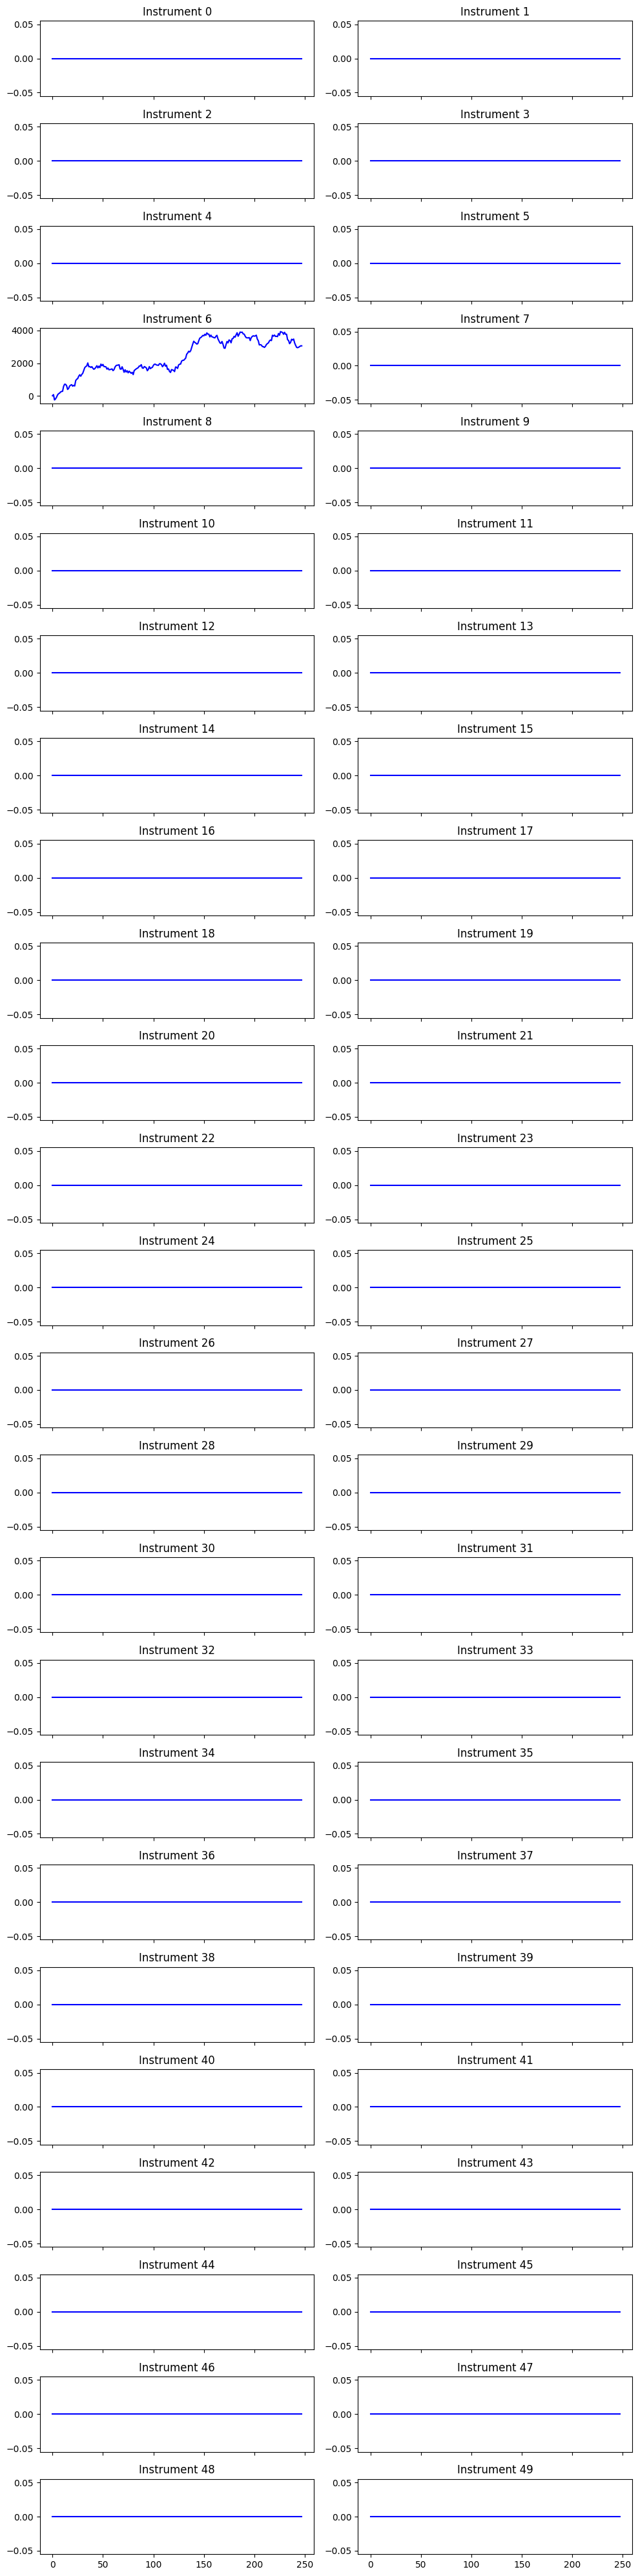

In [29]:
def macd_signal(prices, short=12, long=26, signal=9):
    p_series = pd.Series(prices)
    day_ema_short = p_series.ewm(span=short, adjust=False).mean()
    day_ema_long = p_series.ewm(span=long, adjust=False).mean()
    day_dif = day_ema_short - day_ema_long
    day_dea = day_dif.ewm(span=signal, adjust=False).mean()
    
    n, m1 = 9, 3
    alpha = 1 / m1
    high_n = p_series.rolling(n).max()
    low_n = p_series.rolling(n).min()
    rsv = (high_n - p_series) / (high_n - low_n) * 100
    lwr1 = rsv.ewm(alpha=alpha, adjust=False).mean()
    lwr2 = lwr1.ewm(alpha=alpha, adjust=False).mean()

    trades = []
    pos = np.zeros(len(prices))
    for i in range(1, len(prices)):
        # Sell: MACD and LWR < 20
        if (dif[i] > 0 and dea[i] > 0) and dif[i-1] > dea[i-1] and dif[i] < dea[i] and lwr1[i] < 20 and lwr2[i] < 20:
            pos[i] = -100  # Close any long, go flat
            trades.append(('sell', prices[i]))
            continue
        # Buy: MACD < 0 and DIF crosses above DEA
        elif (dif[i] < 0 and dea[i] < 0) and dif[i-1] < dea[i-1] and dif[i] > dea[i] and lwr1[i] > 80 and lwr2[i] > 80:
            pos[i] = 100  # Go long
            trades.append(('buy', prices[i]))
            continue
        
        if pos[i-1] > 0:
            pos[i] = 0
        
        elif pos[i-1] < 0 and p_series[i] > p_series[i-1]:
            pos[i] = 0
        
        else:
            pos[i] = pos[i-1]

    return pos

def holding(inst):
    if inst == 6:
        return -10000
    else:
        return 0

def backtest(start, end):
    nInst, nt = prices.shape
    commRate = 0.0005
    dlrPosLimit = 10000
    num_days = end - start

    inst_pnls = []
    scores = []

    for inst in range(50):
        print(len(prices[inst]))
        prc = prices[inst, start:end]
        # pos = macd_signal(prc)
        pos = holding(inst)
        posLimits = np.array([int(x) for x in dlrPosLimit / prc])
        pos = np.clip(pos, -posLimits, posLimits)

        cash = 0
        curPos = 0
        values = []
        for t in range(1, num_days):
            newPos = pos[t]
            deltaPos = newPos - curPos
            dvolume = prc[t] * abs(deltaPos)
            comm = dvolume * commRate
            cash -= prc[t] * deltaPos + comm
            curPos = newPos
            posValue = curPos * prc[t]
            value = cash + posValue
            values.append(value)

        pnl = np.diff(np.array(values))
        cum_pnl = np.cumsum(pnl)
        inst_pnls.append(cum_pnl)
        values = np.array(values)
        meanpl = np.mean(pnl)
        plstd = np.std(pnl)
        score = meanpl - 0.1 * plstd
        scores.append(score)
        print(f"Asset {inst}: Score={score:.2f}, Final CumPnL={cum_pnl[-1]:.2f}")

    print("Total score:", np.sum(scores))
    print("Total P&L:", np.sum([p[-1] for p in inst_pnls]))
    # Plot cumulative P&L for all assets
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(25, 2, figsize=(10, 40), sharex=True)
    axes = axes.flatten()
    for inst in range(nInst):
        inst_pnl = pd.Series(inst_pnls[inst])
        axes[inst].plot(inst_pnl, color='blue')
        axes[inst].set_title(f'Instrument {inst}')
        # axes[inst].set_xlabel('Time')
        # axes[inst].set_xlim([start, end])
    plt.tight_layout()
    plt.show()

backtest(500, 750)

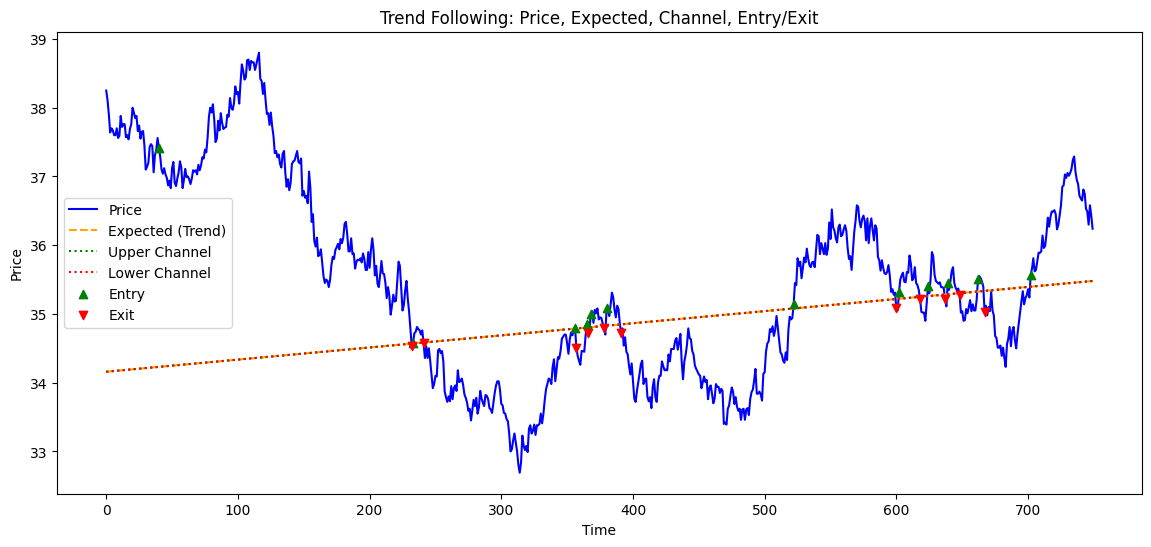

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trend_following(prices, START_LAG=40, FREEDOM_FACTOR=0.1, SLOPE_ENTRY=1e-3, SLOPE_EXIT=5e-5, CHANGE_HOLDING=500, DLR_POS_LIMIT=10_000):
    prices = np.asarray(prices)
    nt = len(prices)
    smooth = np.cumsum(prices) / (np.arange(1, nt+1))
    x = np.arange(nt)
    # Calculate slope using only the last START_LAG days
    if nt >= START_LAG:
        x_lag = x[-START_LAG:]
        y_lag = smooth[-START_LAG:]
        slope, intercept = np.polyfit(x_lag, y_lag, 1)
    else:
        slope, intercept = np.polyfit(x, smooth, 1)
    expected = slope * x + intercept
    freedom = abs(slope) * FREEDOM_FACTOR
    upper = expected + freedom
    lower = expected - freedom

    # Simulate the entry/exit logic
    pos = np.zeros(nt, dtype=int)
    in_position = 0
    for t in range(START_LAG, nt):
        curPrice = prices[t]
        exp = expected[t]
        up = upper[t]
        lo = lower[t]
        flat_trend = abs(slope) < SLOPE_EXIT
        out_of_band_opposite = (
            (in_position > 0 and curPrice < exp) or
            (in_position < 0 and curPrice > exp)
        )
        # Exit
        if flat_trend or out_of_band_opposite:
            in_position = 0
        # Entry/add
        elif abs(slope) >= SLOPE_ENTRY:
            if curPrice > up and slope > 0:
                size = int(np.floor(CHANGE_HOLDING / curPrice))
                in_position += size
            elif curPrice < lo and slope < 0:
                size = int(np.floor(CHANGE_HOLDING / curPrice))
                in_position -= size
        # Risk cap
        max_shares = int(np.floor(DLR_POS_LIMIT / curPrice))
        in_position = np.clip(in_position, -max_shares, max_shares)
        pos[t] = in_position

    # Find entry/exit points for plotting
    entries = np.where((pos[1:] != 0) & (pos[:-1] == 0))[0] + 1
    exits = np.where((pos[1:] == 0) & (pos[:-1] != 0))[0] + 1

    plt.figure(figsize=(14,6))
    plt.plot(prices, label='Price', color='blue')
    plt.plot(expected, label='Expected (Trend)', color='orange', linestyle='--')
    plt.plot(upper, label='Upper Channel', color='green', linestyle=':')
    plt.plot(lower, label='Lower Channel', color='red', linestyle=':')
    plt.scatter(entries, prices[entries], marker='^', color='green', label='Entry', zorder=5)
    plt.scatter(exits, prices[exits], marker='v', color='red', label='Exit', zorder=5)
    plt.title('Trend Following: Price, Expected, Channel, Entry/Exit')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example usage
prices = loadPrices(pricesFile)[0]  # Load the first instrument's prices
plot_trend_following(prices)